In [1]:
#First, I'll compute the camera calibration using chessboard images
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline
# to plot figures correctly

In [2]:
#### obtain calibration parameters
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
	img =  mpimg.imread(fname)
	gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

	# Find the chessboard corners
	ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

	# If found, add object points, image points
	if ret == True:
		objpoints.append(objp)
		imgpoints.append(corners)

		# Draw and display the corners
		img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
		cv2.imshow('img',img)
		cv2.waitKey(50)
cv2.destroyAllWindows()


In [3]:
# a function that takes an image, object points, and image points
# performs the camera calibration, image distortion correction and 
# returns the undistorted image
def cal_undistort(img, objpoints, imgpoints):
	# Use cv2.calibrateCamera and cv2.undistort()
	ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[0:2],None,None)
	undist = cv2.undistort(img, mtx, dist, None, mtx)
	return undist, mtx, dist


# MODIFY THIS FUNCTION TO GENERATE OUTPUT 
# THAT LOOKS LIKE THE IMAGE ABOVE
def unwarp(img, mtx, dist):
	# Pass in your image into this function
	# Write code to do the following steps


	undist = cv2.undistort(img, mtx, dist, None, mtx)
	# gray = cv2.cvtColor(undist,cv2.COLOR_RGB2GRAY)
	# img = gray
	img_size = (img.shape[1],img.shape[0])

	src = np.float32([ul, ur, lr, ll])
	offset = 100

	dst = np.float32([[offset, offset], [img_size[0] - offset, offset],
		[img_size[0] - offset, img_size[1] - offset], [offset, img_size[1] - offset]])

	dst = np.float32([ul_new, ur_new, lr_new, ll_new])
	plt.imshow(img)

	M = cv2.getPerspectiveTransform(src, dst)
	img_size = (img.shape[1],img.shape[0])
	warped = cv2.warpPerspective(undist, M, img_size, flags=cv2.INTER_LINEAR)

	return warped, M

In [35]:

# Define a function that applies Sobel x and y, 
# then computes the direction of the gradient
# and applies a threshold.
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    # Apply threshold
#     gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray = img
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    grad_binary = binary_output
    return grad_binary

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    # Apply threshold
#     gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray = img
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    
    direction = np.absolute(np.sqrt(sobelx**2 + sobely**2))

    sxbinary = np.zeros_like(direction)
    sxbinary[(direction >= mag_thresh[0]) & (direction <= mag_thresh[1])] = 1

    mag_binary = sxbinary
    return mag_binary

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    # 2) Take the gradient in x and y separately
    # 3) Take the absolute value of the x and y gradients
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    # 5) Create a binary mask where direction thresholds are met
    # 6) Return this mask as your binary_output image
#     gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray = img
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    
    direction = np.arctan2(abs_sobely, abs_sobelx)

    sxbinary = np.zeros_like(direction)
    sxbinary[(direction >= thresh[0]) & (direction <= thresh[1])] = 1

    dir_output = sxbinary
    return dir_output

In [38]:
# Edit this function to create your own pipeline.
def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):

	########### Apply a distortion correction to raw images.
	undistorted = cv2.undistort(img, mtx, dist, None, mtx)


	########### Use color transforms, gradients, etc., to create a thresholded binary image.
	# Convert to HSV color space and separate the V channel
	hls = cv2.cvtColor(undistorted, cv2.COLOR_RGB2HLS).astype(np.float)
	l_channel = hls[:,:,1]
#     img = np.array(img, dtype=np.uint8)

	s_channel = hls[:,:,2]
	
	hsv = cv2.cvtColor(undistorted, cv2.COLOR_RGB2HSV).astype(np.float)
	v_channel = hsv[:,:,2]

	# Sobel x
	sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
	abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
	scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
	
	# Threshold x gradient
	sxbinary = np.zeros_like(scaled_sobel)
	sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
	
	# Threshold color channel
	s_binary = np.zeros_like(s_channel)
	s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Most important part!!!!
	lumAbsBin =abs_sobel_thresh(l_channel,'x',3,(20,100)) 
	xAbsBin = abs_sobel_thresh(s_channel,'x',3,(20,100))
	yAbsBin = abs_sobel_thresh(s_channel,'y',3,(20,100))
	magBin = mag_thresh(v_channel,9,(30,100))
	dirBin = dir_threshold(v_channel,15,(0.7,1.2))
    
    
	# Stack each channel
	# Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
	# be beneficial to replace this channel with something else.
	color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
	# Combine the two binary thresholds
	combined_binary = np.zeros_like(sxbinary)
# 	combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
	combined_binary[(v_channel >= 227 | ((s_channel >= 150) | (xAbsBin == 1)) | ((magBin == 1) & (dirBin == 0)))] = 1

	########### Apply a perspective transform to rectify binary image ("birds-eye view").
	img_size = (img.shape[1],img.shape[0])
	src = np.float32([ul, ur, lr, ll])
	dst = np.float32([ul_new, ur_new, lr_new, ll_new])
	# plt.imshow(img)

	M = cv2.getPerspectiveTransform(src, dst)
	img_size = (img.shape[1],img.shape[0])
	warped = cv2.warpPerspective(combined_binary, M, img_size, flags=cv2.INTER_LINEAR)

	return color_binary, combined_binary, warped, undistorted



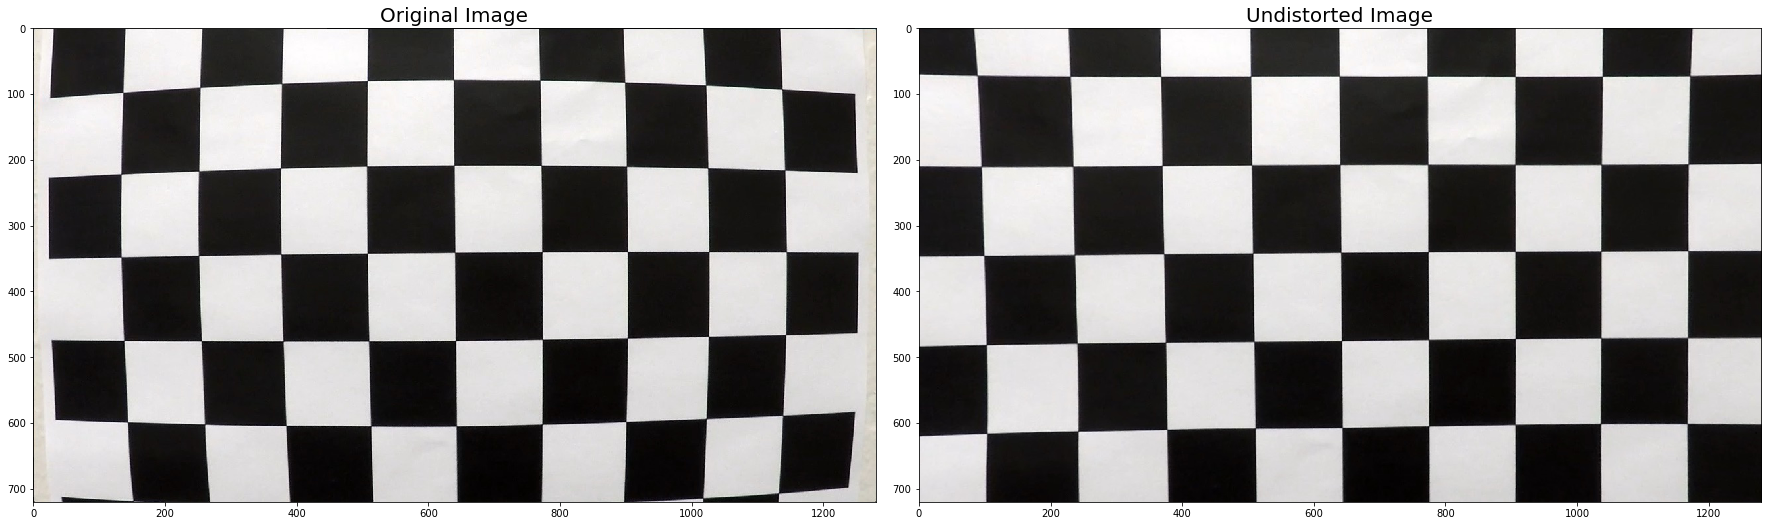

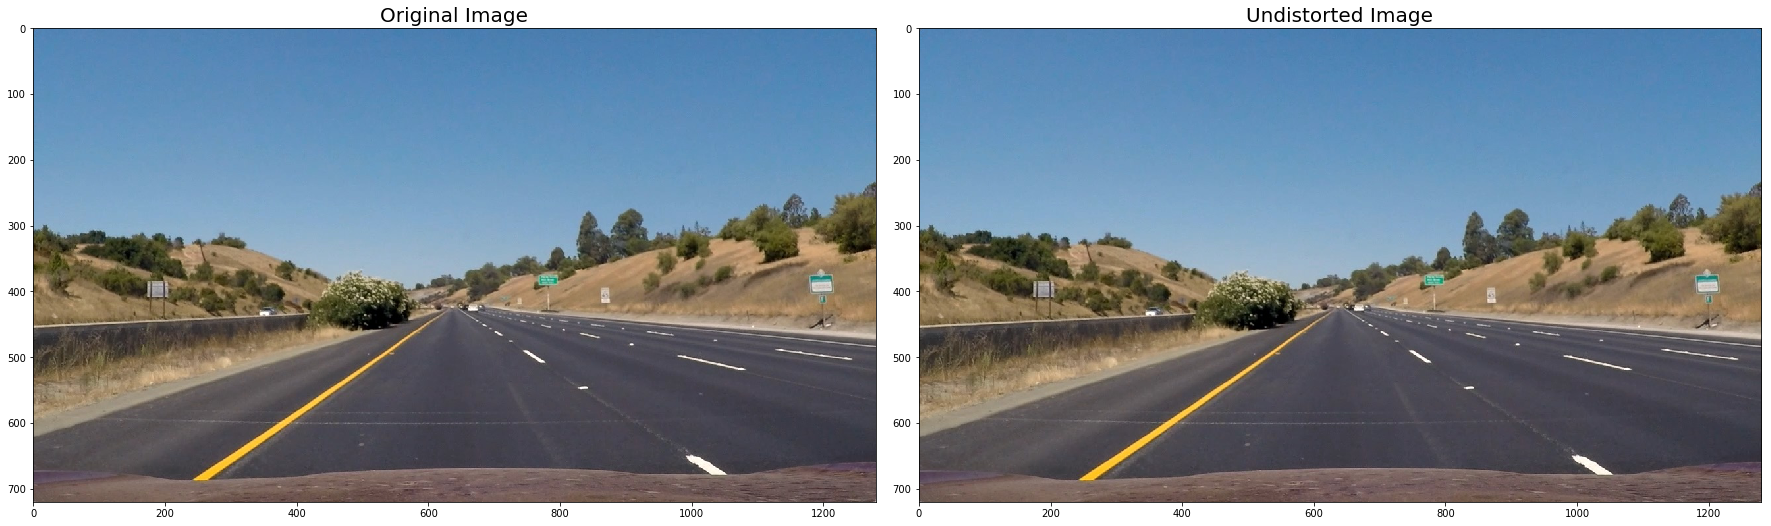

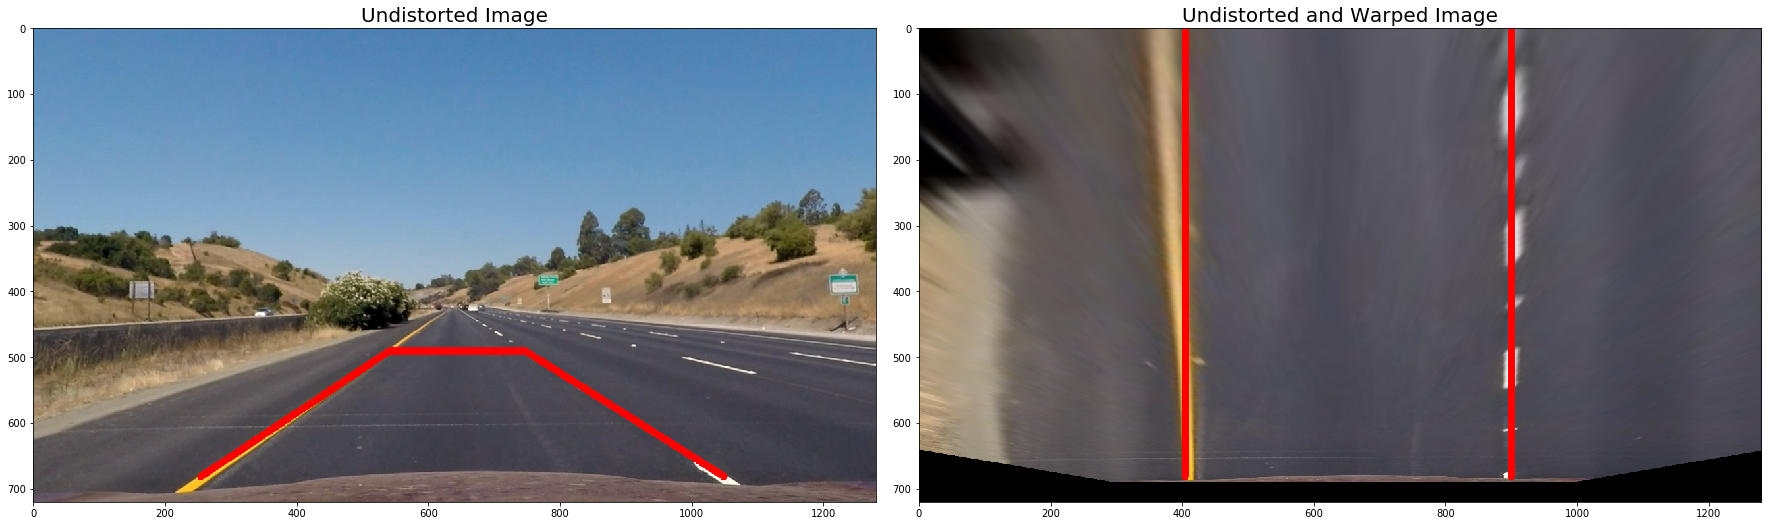

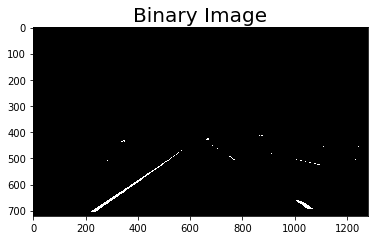

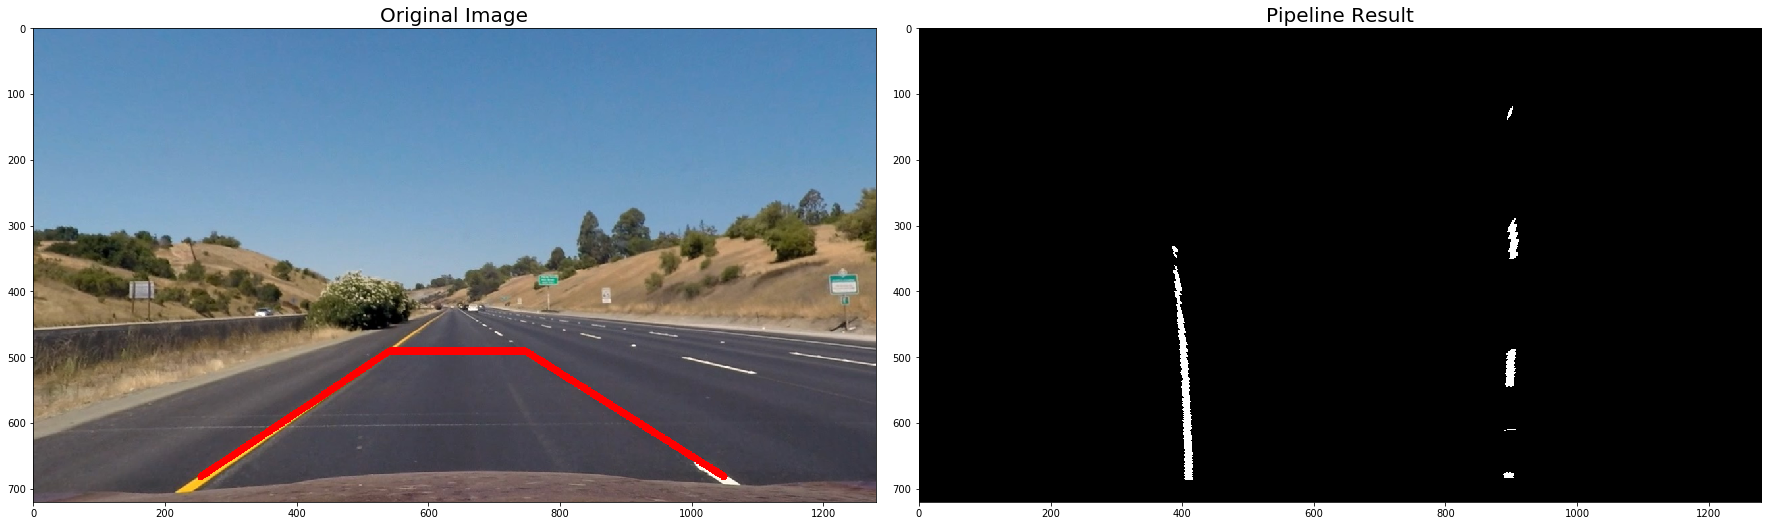

In [39]:
# Next, read in a image and undistort it.
# Read in an image
img = mpimg.imread('camera_cal/calibration1.jpg')

undistorted, mtx, dist = cal_undistort(img, objpoints, imgpoints)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)



# Next, perform thresholding, output binary image

img = mpimg.imread('test_images/straight_lines1.jpg')
# img = image


undistorted, mtx, dist = cal_undistort(img, objpoints, imgpoints)


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


#The four points are obtained through pickPoints.py
ul = [541, 490]   # upper left point
ur = [747, 490] # upper right point
ll = [254, 681] # lower left point
lr = [1049, 681] # lower right point

# ul = [544, 481]   # upper left point
# ur = [738, 481] # upper right point
# ll = [205, 714] # lower left point
# lr = [1086, 714] # lower right point
offset = 150

ul_new = [ll[0] + offset, ul[1]]   # upper left point
ur_new = [lr[0] - offset, ur[1]] # upper right point
ll_new = [ll[0] + offset, ll[1]] # lower left point
lr_new = [lr[0] - offset, lr[1]] # lower right point
# print(ul_new, ur_new, ll_new, lr_new)


color=[255, 0, 0]
top_down, perspective_M = unwarp(img, mtx, dist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
img_line = cv2.undistort(img, mtx, dist, None, mtx)
cv2.line(img_line, tuple(ll), tuple(ul), color,10)#
cv2.line(img_line, tuple(lr), tuple(ur), color,10)#
cv2.line(img_line, tuple(ul), tuple(ur), color,10)#
ax1.imshow(img_line)
ax1.set_title('Undistorted Image', fontsize=20)

cv2.line(top_down, tuple(ll_new), tuple([ul_new[0], 0]), color,10)#
cv2.line(top_down, tuple(lr_new), tuple([ur_new[0], 0]), color,10)#
ax2.imshow(top_down)
ax2.set_title('Undistorted and Warped Image', fontsize=20)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
# plt.show()


combined_binary, warped = pipeline(img)[1:3]


# Plot the result
plt.figure()
plt.imshow(combined_binary, cmap='gray')
plt.title('Binary Image', fontsize=20)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img_line)
ax1.set_title('Original Image', fontsize=20)

ax2.imshow(warped, cmap='gray')
ax2.set_title('Pipeline Result', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


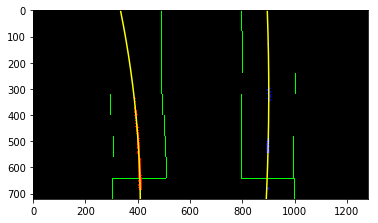

In [40]:
'''Find vehicle position'''
binary_warped = warped
# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint



# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
	# Identify window boundaries in x and y (and right and left)
	win_y_low = binary_warped.shape[0] - (window+1)*window_height
	win_y_high = binary_warped.shape[0] - window*window_height
	win_xleft_low = leftx_current - margin
	win_xleft_high = leftx_current + margin
	win_xright_low = rightx_current - margin
	win_xright_high = rightx_current + margin
	# Draw the windows on the visualization image
	cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2)
	cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2)
	# Identify the nonzero pixels in x and y within the window
	good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
	good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
	# Append these indices to the lists
	left_lane_inds.append(good_left_inds)
	right_lane_inds.append(good_right_inds)
	# If you found > minpix pixels, recenter next window on their mean position
	if len(good_left_inds) > minpix:
		leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
	if len(good_right_inds) > minpix:
		rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds]
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)


# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

plt.figure()
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

In [41]:
# def window_mask(width, height, img_ref, center, level):
#     output = np.zeros_like(img_ref)
#     output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width)):min(int(center*width),img_ref.shape[1])] = 1
#     return output

# window_width = 25
# window_height = 80

# # set up the overall class to do all the tracking
# curve_centers = tracker(Mywindow_width = window_width, Mywindow_height = window_height, Mymargin = 25, My_ym = 10/720, My_xm = 4/384, Mysmooth_factor = 15)

# warped = result
# window_centroids = curve_centers.find_window_centroids(warped)

# l_points = np.zeros_like(warped)
# r_points = np.zeros_like(warped)

# for level in range(0, len(window_centroids)):
#     l_mask = window_mask(window_width, window_height, warped, window_centroids[level][0],level)
#     r_mask = window_mask(window_width, window_height, warped, window_centroids[level][1],level)
#     # add graphic points from window mask here to total pixels found
#     l_points[(l_ponits==255) | ((l_mask==1))] = 255
#     r_points[(r_points==255) | ((r_mask==1))] = 255
    
# # draw the result
# template = np.array(r_points+l_points, np.unit8)
# zero_channel = np.zeros_like(template)
# template = np.array(cv2.merge((zero_channel, template, zero_channel)), np.unit8)
# warpage = np.array(cv2.merge((warped, warped, warped)),np.unit8)
# result = cv2.addWeighted(warpage, 1, template, 0.5, 0.0)


In [42]:
def curvature_1st(left_fit, right_fit, left_fit_cr, right_fit_cr, ploty):
    '''Curvature Calculation'''
    # ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
    # quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
    # # For each y position generate random x position within +/-50 pix
    # # of the line base position in each case (x=200 for left, and x=900 for right)
    # leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51)
    # 							  for y in ploty])
    # rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51)
    # 								for y in ploty])
    #
#     leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
#     rightx = rightx[::-1]  # Reverse to match top-to-bottom in y
    #
    #
    # Fit a second order polynomial to pixel positions in each fake lane line
#     left_fit = np.polyfit(ploty, leftx, 2)
    right_fit = right_fit_cr
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
#     right_fit = np.polyfit(ploty, rightx, 2)
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Plot up the fake data
    mark_size = 3
#     plt.figure()
# #     plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
# #     plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
# #     plt.xlim(0, 1280)
# #     plt.ylim(0, 720)
#     plt.plot(left_fitx, ploty, color='green', linewidth=3)
#     plt.plot(right_fitx, ploty, color='green', linewidth=3)
#     plt.gca().invert_yaxis() # to visualize as we do the images

    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
#     print('Curvature in pixel,', 'left:', left_curverad, 'right:', right_curverad)


    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
#     print('Lane curvatures, left:', left_curverad, 'm, right:', right_curverad, 'm')
    return left_curverad, right_curverad




Vehicle is -0.06 m left of center.
Lane curvatures, left: 1230.59995381 m, right: 2843.5885977 m


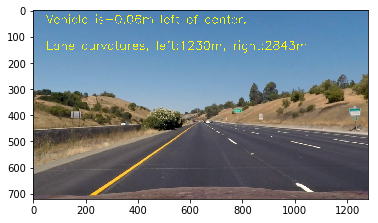

In [43]:
# put curvature and distance from the center of lane on an image
font = cv2.FONT_HERSHEY_SIMPLEX
# print('left lane center,', leftx_base, 'right lane center,', rightx_base)
lane_center = (leftx_base + rightx_base) / 2
vehicle_center = warped.shape[1] / 2
# print('centers, lane,', lane_center, 'vehicle,', vehicle_center)
difference = vehicle_center - lane_center
if difference > 0:
	print('Vehicle is', round(difference * 3.7/700, 2), 'm right of center.')
	cv2.putText(undistorted, ('Vehicle is', round(difference * 3.7/700, 2), 'm right of center.'), (50, 50), font, 1.5, (255, 255, 0), 2)
elif difference < 0:
	print('Vehicle is', round(difference * 3.7/700, 2), 'm left of center.')
	cv2.putText(undistorted, 'Vehicle is' + str(round(difference * 3.7/700, 2)) + 'm left of center.', (50, 50), font, 1.5, (255, 255, 0), 2)
else:
    print('Vehicle is on the center.')
    cv2.putText(undistorted, 'Vehicle is on the center.', (50, 50), font, 1.5, (255, 255, 0), 2)

left_curverad, right_curverad = curvature_1st(left_fit, right_fit, left_fit_cr, right_fit_cr, ploty)
print('Lane curvatures, left:', left_curverad, 'm, right:', right_curverad, 'm')
cv2.putText(undistorted, 'Lane curvatures, left:'+ str(int(left_curverad)) + 'm, right:'+ str(int(right_curverad)) + 'm', (50, 150), font, 1.5,(255, 255, 0), 2)

plt.imshow(undistorted)

In [44]:
def curvature(left_fitx, right_fitx, ploty):
    '''Curvature Calculation'''

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    leftx = left_fitx
    rightx = right_fitx
    
    y_eval = np.max(ploty)

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
   
      
    return left_curverad, right_curverad


720 720


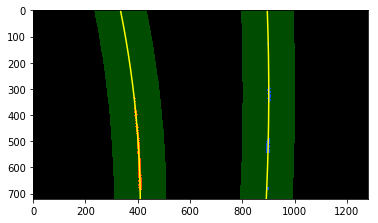

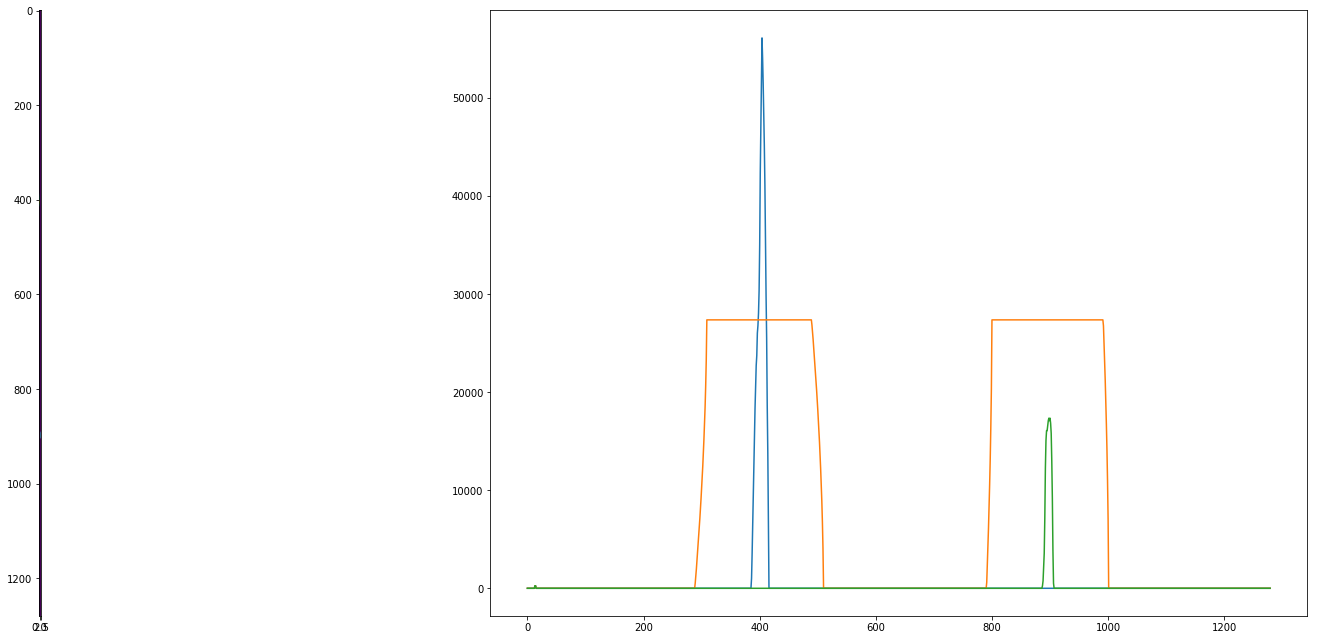

720 720
(1230.5999538106605, 2843.5885977036942)


In [45]:
'''for later images'''
# Assume you now have a new warped binary image
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin)))
right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds]
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

print(len(left_fitx), len(right_fitx))

'''visualize result'''
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)



img = result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
plt.plot(histogram)
ax1.imshow(histogram)
#
# '''Drawing the lines back down onto the road'''
# # Create an image to draw the lines on
# warp_zero = np.zeros_like(result).astype(np.uint8)
# color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
#
# # Recast the x and y points into usable format for cv2.fillPoly()
# pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
# pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
# pts = np.hstack((pts_left, pts_right))
#
# # Draw the lane onto the warped blank image
# cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
#
# # Warp the blank back to original image space using inverse perspective matrix (Minv)
# newwarp = cv2.warpPerspective(color_warp, perspective_M, (img.shape[1], img.shape[0]))
# # Combine the result with the original image
# result = cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0)
# plt.imshow(result)
plt.show()
print(len(left_fitx), len(right_fitx))

print(curvature(left_fitx, right_fitx, ploty))

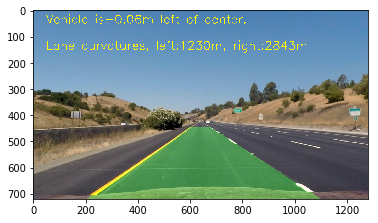

In [46]:
# Create an image to draw the lines on
from numpy.linalg import inv
warp_zero = np.zeros_like(warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
Minv = inv(perspective_M)
newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0)
plt.imshow(result)

In [47]:
global polygon_points_old
polygon_points_old = None

def process(img, Minv, left_fit, right_fit):
       
    warped, undistorted = pipeline(img)[-2:]
    
    # find vehicle location
    binary_warped = warped
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    lane_center = (leftx_base + rightx_base) / 2
    vehicle_center = warped.shape[1] / 2
    # print('centers, lane,', lane_center, 'vehicle,', vehicle_center)
    difference = vehicle_center - lane_center
    if difference > 0:
#         print('Vehicle is', round(difference * 3.7/700, 2), 'm right of center.')
        cv2.putText(undistorted, ('Vehicle is '+ str(round(difference * 3.7/700, 2)) + 'm right of center.'), (50, 50), font, 1.5, (255, 255, 0), 2)
    elif difference < 0:
        difference = -1 * difference
#         print('Vehicle is ', round(difference * 3.7/700, 2), 'm left of center.')
        cv2.putText(undistorted, 'Vehicle is ' + str(round(difference * 3.7/700, 2)) + 'm left of center.', (50, 50), font, 1.5, (255, 255, 0), 2)
    else:
#         print('Vehicle is on the center.')
        cv2.putText(undistorted, 'Vehicle is on the center.', (50, 50), font, 1.5, (255, 255, 0), 2)
    
    # find lane curvature
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    left_curverad, right_curverad = curvature(left_fitx, right_fitx, ploty)
    cv2.putText(undistorted, 'Lane curvatures, left:'+ str(int(left_curverad)) + 'm, right:'+ str(int(right_curverad)) + 'm', (50, 150), font, 1.5,(255, 255, 0), 2)

#     print(curvature(left_fitx, right_fitx, ploty))
    
    
    ########### draw lane area on the undistorted image
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
#     print(pts.shape)
    
    ####### credits: from reviewer.#############
    polygon_points = pts[0]
    global polygon_points_old
    
    
    # delete weird points
    pts_new = []
    for pt in polygon_points:
        if pt[1] > 500:
            pts_new.append(pt)
#             print('x,y:',pt)

    
    polygon_points = np.array(pts_new[:])
    pts = polygon_points
    
    if (polygon_points_old == None):
        polygon_points_old = polygon_points

    a = polygon_points_old
    b = polygon_points
#     print(a.shape,b)
    ret = cv2.matchShapes(a,b,1,0.0)

    if (ret < 0.045):
        # Use the new polygon points to write the next frame due to similarites of last sucessfully written polygon area

        polygon_points_old = polygon_points

    else:
        # Use the old polygon points to write the next frame due to irregularities
        # Then write the out the old polygon points
        # This will help only use your good detections
        pts = polygon_points_old
        
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0)
#     plt.imshow(result)
    return result
def process_image(img):
    return process(img, Minv, left_fit, right_fit)

# img = mpimg.imread('test_images/test1.jpg')

# process_image(img)

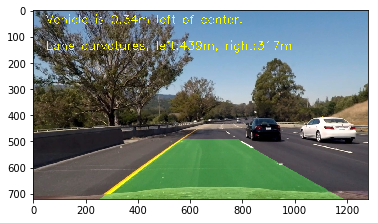

In [49]:
image = mpimg.imread('test_images/test6.jpg')
img = process_image(image)
plt.imshow(img)

In [50]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML


test_input = 'project_video.mp4'
#     test_input = 'chanllenge_video.mp4'
#     test_input = 'hard_challenge_video.mp4'


test_output = 'project.mp4'
#     test_output = 'challenge.mp4'
#     test_output = 'hard_challenge.mp4'

clip = VideoFileClip(test_input)

test_clip = clip.fl_image(process_image)

test_clip.write_videofile(test_output, audio=False)

[MoviePy] >>>> Building video project.mp4
[MoviePy] Writing video project.mp4


100%|█████████████████████████████████████▉| 1260/1261 [10:43<00:00,  1.97it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project.mp4 



In [51]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_output))